In [1]:
from openelm import ELM
from openelm.environments.environments import (
        BaseEnvironment,
        FunctionOptim,
        ImageOptim,
        MatchString,
        Sodarace
    )
from openelm.map_elites import MAPElites, Map
import numpy as np
from openelm.codegen.codegen_utilities import truncate

In [12]:
from openelm.environments.sodaracer.walker.square import make_walker as make_walker_square
from openelm.environments.sodaracer.walker.radial import make_walker as make_walker_radial
from openelm.environments.sodaracer.walker.CPPN_fixed import make_walker as make_walker_cppn_fixed
from openelm.environments.sodaracer.walker.CPPN_mutable import make_walker as make_walker_cppn_mutable

In [13]:
square = make_walker_square()
radial = make_walker_radial()
cppn_fixed = make_walker_cppn_fixed()
cppn_mutable = make_walker_cppn_mutable()

In [114]:
square.to_dict()

{'joints': [(0, 0), (0, 10), (10, 10), (10, 0), (5, 5)],
 'muscles': [[0, 1, {'type': 'distance', 'amplitude': 0.0, 'phase': 0.0}],
  [1, 2, {'type': 'distance', 'amplitude': 0.0, 'phase': 0.0}],
  [2, 3, {'type': 'distance', 'amplitude': 0.0, 'phase': 0.0}],
  [3, 0, {'type': 'distance', 'amplitude': 0.0, 'phase': 0.0}],
  [3, 4, {'type': 'distance', 'amplitude': 0.0, 'phase': 0.0}],
  [0, 4, {'type': 'muscle', 'amplitude': 5.0, 'phase': 0.0}],
  [1, 4, {'type': 'muscle', 'amplitude': 10.0, 'phase': 0.0}],
  [2, 4, {'type': 'muscle', 'amplitude': 2.0, 'phase': 0.0}]]}

In [5]:
square.validate(), radial.validate()

(True, True)

In [25]:
from openelm.environments.sodaracer.simulator import IESoRWorld

In [111]:
myWorld = IESoRWorld()

In [112]:
initial_dict = myWorld.load_body_into_world(square.to_dict(), myWorld.canvas)

In [106]:
initial_dict

{'width': 413.2231404958677,
 'height': 240.0,
 'startX': 0.0,
 'offsetX': -106.61157024793386,
 'startY': -216.0,
 'offsetY': 171.0,
 'mass': 1136.0864722563908}

In [109]:
x_pos, y_pos = [], []
for i in range(1000):
    x_pos.append(min(
    [bone.joint.bodyA.position.x for bone in myWorld.bone_list] +
    [muscle.joint.bodyA.position.x for muscle in myWorld.muscle_list]
))
    y_pos.append(min(
    [bone.joint.bodyA.position.y for bone in myWorld.bone_list] +
    [muscle.joint.bodyA.position.y for muscle in myWorld.muscle_list]
))
    myWorld.updateWorld(350)

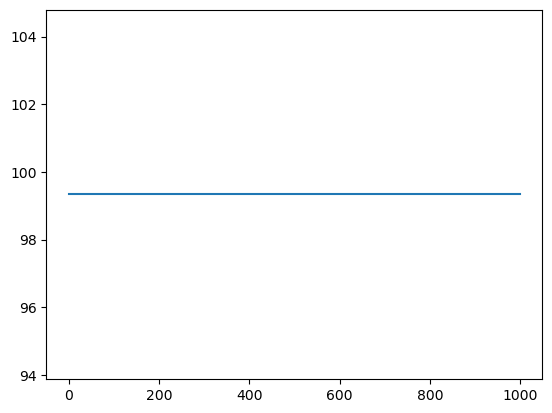

In [110]:
import matplotlib.pyplot as plt
plt.plot(x_pos)
# plt.plot(y_pos)

In [113]:
[myWorld.updateWorld(350) for i in range(1000)]
start = initial_dict['startX']
# Could potentially just grab the bones instead, but if it's all 
# muscle then you'd need to grab a muscle.
end = min(
    [bone.joint.bodyA.position.x for bone in myWorld.bone_list] +
    [muscle.joint.bodyA.position.x for muscle in myWorld.muscle_list]
)
print(start, abs(end + initial_dict['offsetX']))

0.0 7.27755535535573


In [2]:
SQUARE_SEED = {
    "program_str": """from openelm.environments.sodaracer.walker.walk_creator import walker_creator


def make_square(wc, x0, y0, x1, y1):
    \"\"\"Make a square with top left x0,y0 and top right x1,y1.\"\"\"
    j0 = wc.add_joint(x0, y0)
    j1 = wc.add_joint(x0, y1)
    j2 = wc.add_joint(x1, y1)
    j3 = wc.add_joint(x1, y0)
    return j0, j1, j2, j3


def make_walker():
    wc = walker_creator()

    # the main body is a square
    sides = make_square(wc, 0, 0, 10, 10)
    center = wc.add_joint(5, 5)

    # connect the square with distance muscles
    for k in range(len(sides) - 1):
        wc.add_muscle(sides[k], sides[k + 1])
    wc.add_muscle(sides[3], sides[0])

    # one prong of the square is a distance muscle
    wc.add_muscle(sides[3], center)

    # the other prongs from the center of the square are active
    wc.add_muscle(sides[0], center, 5.0, 0.0)
    wc.add_muscle(sides[1], center, 10.0, 0.0)
    wc.add_muscle(sides[2], center, 2.0, 0.0)

    return wc.get_walker()

""",
    "result_dict": {
        "joints": [(0, 0), (0, 10), (10, 10), (10, 0), (5, 5)],
        "muscles": [
            [0, 1, {"type": "distance", "amplitude": 0.0, "phase": 0.0}],
            [1, 2, {"type": "distance", "amplitude": 0.0, "phase": 0.0}],
            [2, 3, {"type": "distance", "amplitude": 0.0, "phase": 0.0}],
            [3, 0, {"type": "distance", "amplitude": 0.0, "phase": 0.0}],
            [3, 4, {"type": "distance", "amplitude": 0.0, "phase": 0.0}],
            [0, 4, {"type": "muscle", "amplitude": 5.0, "phase": 0.0}],
            [1, 4, {"type": "muscle", "amplitude": 10.0, "phase": 0.0}],
            [2, 4, {"type": "muscle", "amplitude": 2.0, "phase": 0.0}],
        ],
    },
}


In [ ]:
truncate(SQUARE_SEED["program_str"])

In [3]:
tst = unsafe_execute(SQUARE_SEED["program_str"])

In [21]:
behavior_space = np.array(
            [[0, 1000], [0, 1000], [0, 2000]]
        ).T
bins = np.linspace(*behavior_space, 12 + 1)[1:-1].T

In [22]:
def to_mapindex(b):
        return (
            None
            if b is None
            else tuple(np.digitize(x, bins) for x, bins in zip(b, bins))
        )

In [40]:
to_mapindex(np.array([917, 413, 1136]))

(11, 4, 6)

In [ ]:
env = Sodarace()
elites = MAPElites(
    self.environment,
    n_bins=self.cfg.behavior_n_bins,
    history_length=self.cfg.evo_history_length,
)